In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from IPython.core.display import display, HTML, Image
import nbconvert
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import sys
sys.path.insert(0, '../src/visualization')
import visualize 
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 20)

<h1 align="center">Genetic Overlap between Alzheimer's, Parkinson’s, and healthy patients</h1>
<h2 align="center">DSC180B, Section B04: Genetics</h2>
<h2 align="center">Justin Lu, Saroop Samra, Xuanyu Wu
</h2>

## Background

<font color = "red"> TODO </font>

## Psychiatric Disorders

### Alzheimers

<font color = "red">TODO</font>


### Parkinsons

<font color = "red"> TODO </font>



## RNA Sequencing

<font color = "red"> TODO </font>



## Pipeline

For this project, we will need to take the two pair-ended .fastq files per patient sample and run a quality check fastqc[<sup>7</sup>](#fn7) on them. Then we use cutadapt[<sup>6</sup>](#fn6) which removes adaptors in order to clean the data (after this we run the quality check again). By doing a quality before and afterwards we can evaluate the effectiveness of the cleaning step. The cleaned data pair will then be transformed by running the align count step, which has two options:

1. kallisto - this is a faster tool and we plan to use. It takes roughly 10 minutes to process a pair with 8 bootstrap samples. The output will be a gene count table for each SRA run.

2. STAR - generate alignments and gene count and we will maintain these as a single file per patient. STAR optionally can output BAM files which are binary sequence alignment files which we do an additional quality check using picard after manual quality checks have confirmed the quality.

The next step is to execute the "merge" step: which takes all the gene count SRA files and merges them in one gene matrix table using Pandas[<sup>14</sup>](#fn14). The output will also be a gene experiments table which identifies the sample labels and the patient features (age, disorder etc). 

After merging, we execute the "normalize" step: this imports the merged gene count matrix into a custom R script which uses the DESeq2[<sup>15</sup>](#fn15) module to generate two normalized matrix counts: one uses standard normalization and the other Variable Stablization Transformation.

After normalizing we execute the "analysis" step: this generates 4 Likelihood Ratio test (LRT), a hypothesis test that compares models in terms of how they fit the available data by comparing the likelihood scores of the models[<sup>9</sup>](#fn9). Each of the 4 LRT's corresponds to a one biofluid and one disorder. The LRT will be compared against that disorder versus the control group. Additionally, an MA Plot and Heatmap are generated.

The overall pipeline is shown in Figure 1 below.

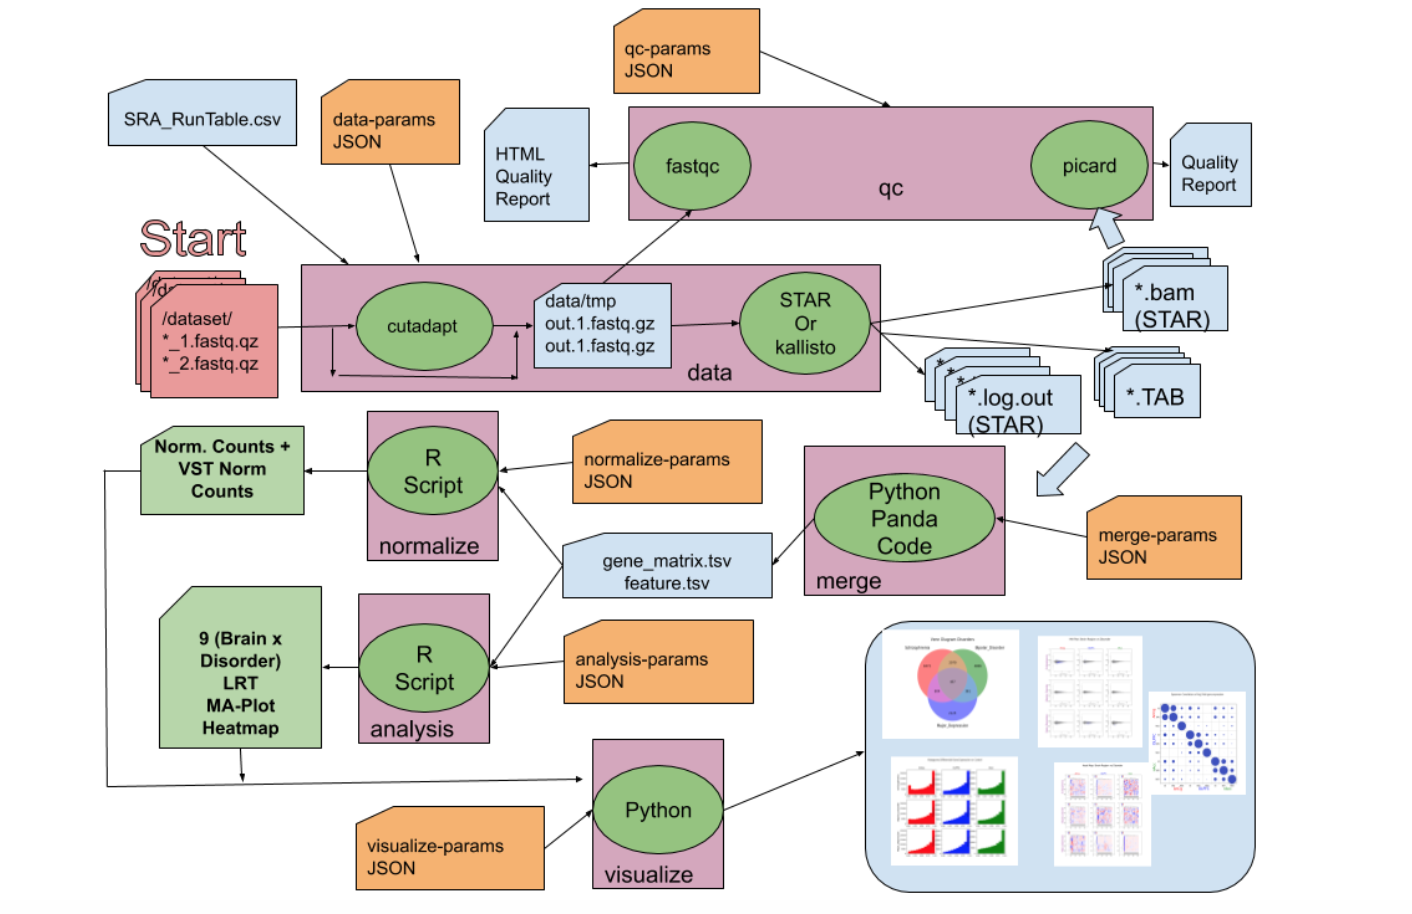

In [2]:
Image("pipeline.png", width=800)
# TODO - Add Cloud with input to data and "circle" with download in it

Figure 1: Our Pipeline

Apart from the fastq files there is also an SRA Run table as an input to the pipeline which is shown below in Table 1.

In [3]:
df = pd.read_csv("../data/raw/exRNA_Atlas_CORE_Results.csv")
df[["Run", "CONDITION", "BIOFLUID", "sex"]]

,Run,CONDITION,BIOFLUID,sex
0,SRR1568567,Healthy Control,Cerebrospinal fluid,male
1,SRR1568730,Parkinson's Disease,Serum,female
2,SRR1568666,Alzheimer's Disease,Serum,female
3,SRR1568510,Parkinson's Disease,Cerebrospinal fluid,male
4,SRR1568518,Parkinson's Disease,Cerebrospinal fluid,female
...,...,...,...,...
336,SRR1568457,Parkinson's Disease,Cerebrospinal fluid,female
337,SRR1568654,Healthy Control,Serum,male
338,SRR1568729,Parkinson's Disease,Cerebrospinal fluid,female
339,SRR1568430,Parkinson's Disease,Cerebrospinal fluid,male


Table 1: <font color = "red"> The SRA Run Table subset acted as our main source for the project, especially when it came to the exploratory data analysis portion of the project. Each row represents a different sample of the brain from a patient diagnosed with one of the three brain disorders or as the control. The information in the table include the patients age at death, their brain ph levels, the post-mortem interval, the brain region, and the diagnosed disorder. </font>

## Quality Checks

#### Cutadapt

TODO

#### FastQC

TODO

#### Data Specificity

TODO






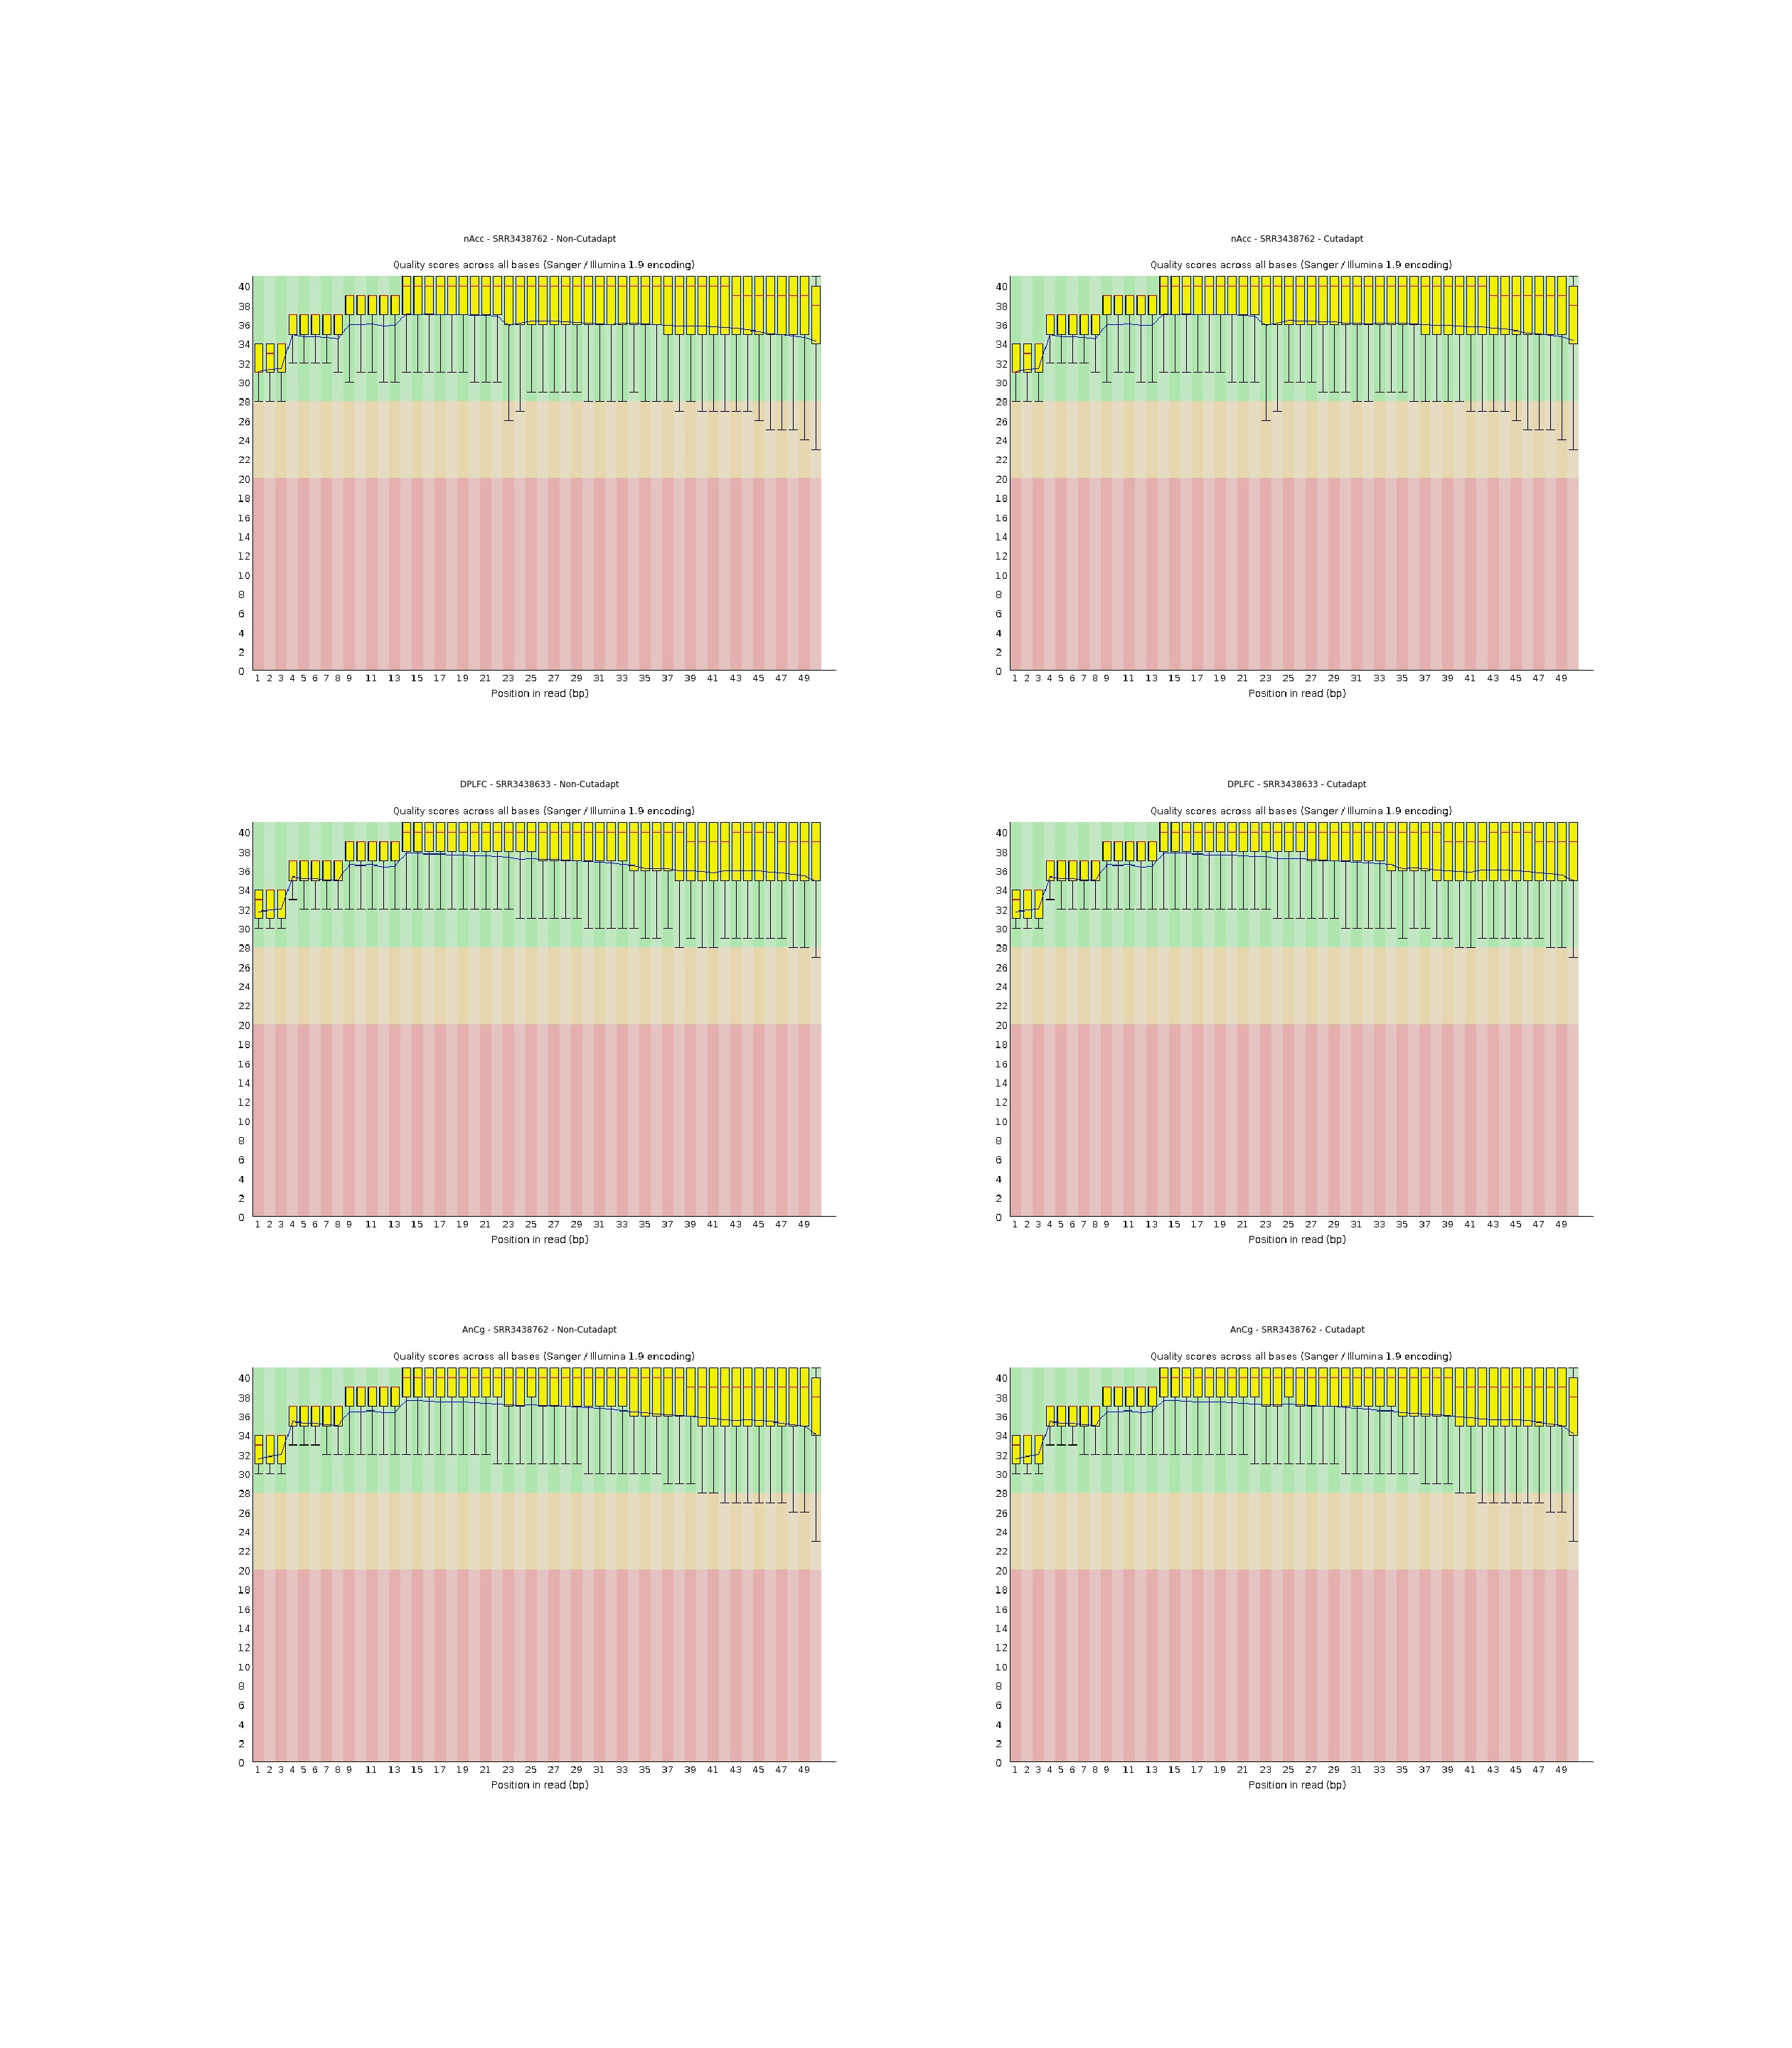

In [4]:
# TODO
Image("cutadapt.png")

#TODO 
Figure 2: (Left) Per Base Sequence Quality visual from FastQC reports of samples, one for each biofluid, that did not have cutadapt applied. (Right) Per Base Sequence Quality visual from FastQC reports of the same samples on the left that did have FastQC applied. 

<font color = "red"> Explain whether we decide to do fastqc/cutadapt or not</font>

## EDA

### Experiments Features Table

In [70]:
sra_data = pd.read_csv("../data/raw/exRNA_Atlas_CORE_Results.csv", index_col=0)


## General Patient Population

<font color = "red"> We performed EDA on our dataset to get acquire a general sense of the data and its contents. To begin, we first removed several columns that were either unnecessary, contained categorical data, and/or contained repeated values that offered no significance. This modified dataframe, "sra_data", is the dataframe in which the rest of our EDA is based on. Table 2 and Table 3 below describe our dataset as a whole, taking into account both the male and female population. </font>

In [58]:
# General Data Description
sra_data.describe().round(3)

,TRANSCRIPTOME READS,REFERENCE GENOME READS,TRANSCRIPTOME GENOME RATIO
count,3.410000e+02,3.410000e+02,341.000
mean,4.141068e+06,4.383814e+06,0.904
std,4.302031e+06,4.334119e+06,0.165
min,8.027000e+04,8.774800e+04,0.200
25%,1.408965e+06,1.631786e+06,0.926
50%,2.841169e+06,3.079164e+06,0.975
75%,5.329869e+06,5.622788e+06,0.986
max,3.123018e+07,3.182475e+07,0.997


Table 2: A table that shows the descriptive analysis of our data with the general population which takes into account both males and females. Each row contains the values associated with the specific statistic metric assigned in the index of the dataframe.

In [59]:
# Data Description broken down by Gender and Clinical Diagnosis
gender_info = sra_data.groupby(['sex','CONDITION'])['TRANSCRIPTOME READS','REFERENCE GENOME READS','TRANSCRIPTOME GENOME RATIO'].mean()
gender_info = gender_info.unstack(level=0)
gender_info.round(3)

TRANSCRIPTOME READS              REFERENCE GENOME READS  \
sex                              female         male                 female   
CONDITION                                                                     
Alzheimer's Disease         4231919.897  3887977.308            4517533.724   
Healthy Control             4008881.661  3520695.500            4266900.589   
Parkinson's Disease         4418880.977  4852520.906            4685596.791   

                                 TRANSCRIPTOME GENOME RATIO         
sex                         male                     female   male  
CONDITION                                                           
Alzheimer's Disease  4124573.942                      0.908  0.894  
Healthy Control      3762768.706                      0.917  0.874  
Parkinson's Disease  5032663.891                      0.894  0.934

<font color = "red"> Table 3: TODO descibe </font>

### TODO - More EDA



## Biofluid Region

During our EDA of the three biofluid regions specified in the replication project, we narrowed our focus on seeing how correlated the two biofluid regions of the study were when it came to the variables <font color="red"> 'age_at_death", "Brain_pH", and "post-mortem_interval". The findings when it came to the anterior cingulate cortex (AnCg) showed it to contain the most correlated values compared to the other two regions. Throughout the remainder of the project, much of the significant conclusions of the project would involve the AnCg.  </font>

#### Mean Break Down of Disorders at Each Biofluid

In [53]:
# Averages broken down by source_name
region_info = sra_data.groupby(['CONDITION', 'BIOFLUID'])['TRANSCRIPTOME READS','REFERENCE GENOME READS','TRANSCRIPTOME GENOME RATIO'].mean()
region_info.round(3)

TRANSCRIPTOME READS  \
CONDITION           BIOFLUID                                   
Alzheimer's Disease Cerebrospinal fluid          4575343.633   
                    Serum                        3462111.120   
Healthy Control     Cerebrospinal fluid          4973991.371   
                    Serum                        2508341.968   
Parkinson's Disease Cerebrospinal fluid          5941878.526   
                    Serum                        3237722.880   

                                         REFERENCE GENOME READS  \
CONDITION           BIOFLUID                                      
Alzheimer's Disease Cerebrospinal fluid             4671781.683   
                    Serum                           3923758.000   
Healthy Control     Cerebrospinal fluid             5087731.919   
                    Serum                           2893150.419   
Parkinson's Disease Cerebrospinal fluid             6046816.842   
                    Serum                           3578051.820   

                                         TRANSCRIPTOME GENOME RATIO  
CONDITION           BIOFLUID                                         
Alzheimer's Disease Cerebrospinal fluid                       0.975  
                    Serum                                     0.813  
Healthy Control     Cerebrospinal fluid                       0.977  
                    Serum                                     0.810  
Parkinson's Disease Cerebrospinal fluid                       0.983  
                    Serum                                     0.844

Table 6: <font color="red">Table showing the mean values of "age_at_death", "brain_pH", and "post-mortem_interval" for the three brain disorders and the control group. Each row of the table represents a particular brain region and a brain disorder group or control group for that region.</font>

#### Correlation Observation of the Serum Biofluid

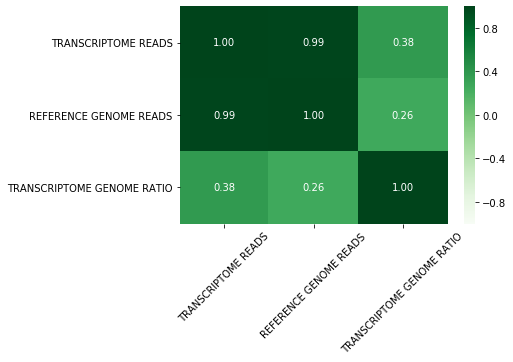

,TRANSCRIPTOME READS,REFERENCE GENOME READS,TRANSCRIPTOME GENOME RATIO
TRANSCRIPTOME READS,1.000,0.986,0.380
REFERENCE GENOME READS,0.986,1.000,0.263
TRANSCRIPTOME GENOME RATIO,0.380,0.263,1.000


In [63]:
# Serum Correlation Observation
Serum_region = sra_data[sra_data['BIOFLUID'].str.contains("Serum")]
Serum_corr_data = Serum_region.corr()
sns.heatmap(Serum_corr_data, annot=True, fmt=".2f", cmap='Greens',vmin=-1.0, vmax=1.0)
plt.xticks(rotation=45)

# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()

Serum_corr_data.round(3)

#TODO
Figure  ### (Top): Heatmap showing the correlations between the quantitative variables found in our dataset. The darker the shade of green, the more correlated the two variables are. The larger the value shown in each box of the heatmap, the greater the correlation as well.

Table ### (Bottom): Table representation of the correlation values from Figure 6 above. The closer the value is to 1, the greater the correlation between two variables.

#### Correlation Observation of the Serum Biofluid

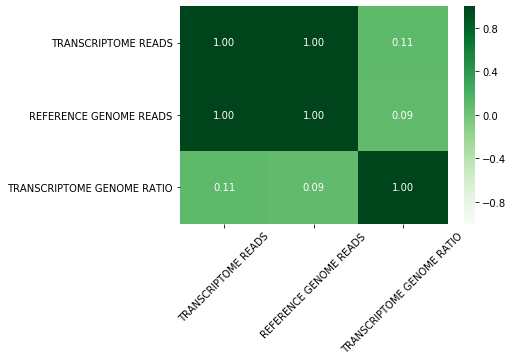

,TRANSCRIPTOME READS,REFERENCE GENOME READS,TRANSCRIPTOME GENOME RATIO
TRANSCRIPTOME READS,1.000,1.000,0.106
REFERENCE GENOME READS,1.000,1.000,0.091
TRANSCRIPTOME GENOME RATIO,0.106,0.091,1.000


In [64]:
# Cerebrospinal fluid Correlation Observation
Cerebrospinal_region = sra_data[sra_data['BIOFLUID'].str.contains("Cerebrospinal fluid")]
Cerebrospinal_corr_data = Cerebrospinal_region.corr()
sns.heatmap(Cerebrospinal_corr_data, annot=True, fmt=".2f", cmap='Greens',vmin=-1.0, vmax=1.0)
plt.xticks(rotation=45)

# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()

Cerebrospinal_corr_data.round(3)

#TODO
Figure ### (Top): Heatmap showing the correlations between the quantitative variables found in our dataset. The darker the shade of green, the more correlated the two variables are. The larger the value shown in each box of the heatmap, the greater the correlation as well.

Table ### (Bottom): Table representation of the correlation values from Figure 6 above. The closer the value is to 1, the greater the correlation between two variables.

## QC Standards

<font color="red">During the EDA we found that 271 of the 351 samples were uniquely assigned to a patient and brain region. However, there were 67 that had repeated SRA runs, and 2 cases that had 3 SRA runs. If we had more time we would have pursued a further analysis of these repeated samples, in particular we would eliminate the repeating samples based on a quality check (e.g. using cutadapt). However, due to lack of time we decided to keep all repeated samples in our analysis.</font>

PASS    323
FAIL     18
Name: MEETS ERCC QC STANDARDS?, dtype: int64

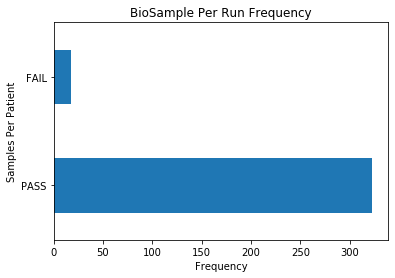

In [56]:
ax = sra_data["MEETS ERCC QC STANDARDS?"].value_counts().plot(kind='barh')
ax.set_xlabel("Frequency")
ax = ax.set_ylabel("Samples Per Patient")
plt.title("BioSample Per Run Frequency")


sra_data["MEETS ERCC QC STANDARDS?"].value_counts()

## Processing of Data

### Gene counting: STAR vs kallisto vs Downloading

Our original plan was to use STAR for alignment and gene counting howwever we decided to leverage kallisto. This decision might impact the quality of the gene count results and differs with the original research paper; however, due to slow performance of STAR we decided to proceed with processing the SRA dataset with kallisto. The kallisto processing still required several days which we executed on our pipeline on the DSLMP server.

<span style="color:red"> ## TODO- run kallisto/STAR ourselves on some files but ultimately use downloaded data </span>

### Merging counts

Kallisto generates a TSV abundance file per SRA run sample. The table has a column that indicates the abundance count. The 350 abundance files were merged into one gene count file. Special care was needed to ensure that the columns and rows matches up - the columns were the SRA runs, and the rows were the gene counts. The output was a table with over 78K genes. However, as mentioned in the research paper, X and Y chromosomes were not considered in the analysis, and after removing these, as well as the genes prefixed with NR accession prefix, this yielded 60,6042 genes. Further cleanup of this to remove false positive resulted in 17,162 genes.  Finally, we also removed the sample: SRR3438888, that we investigated during EDA had null data generated from kallisto. A portion of the final gene matrix table is shown in Table 8 below. 

In [17]:
df1 = pd.read_csv("../data/out/gene_matrix.tsv", sep='\t', index_col=0)
df1.iloc[0:6:,0:6].round(3)

,SRR1568379,SRR1568667,SRR1568620,SRR1568684,SRR1568555,SRR1568407
ENST00000384687.1:snRNA:RNVU1-7-201,37.0,97.0,48.0,102.0,35.0,338.0
ENST00000391107.1:misc_RNA:RNY4P18-201,85.0,109.0,66.0,92.0,105.0,69.0
ENST00000516861.1:misc_RNA:Y_RNA.784-201,65.0,78.0,21.0,106.0,34.0,50.0
ENST00000387347.2:Mt_rRNA:MT-RNR2-201,469.0,424.0,290.0,278.0,437.0,1211.0
ENST00000493013.2:misc_RNA:RN7SL767P-201,174.0,151.0,89.0,201.0,150.0,326.0
ENST00000363640.1:misc_RNA:RNY4P2-201,133.0,130.0,36.0,104.0,46.0,206.0


Table 8: Subset of the gene matrix showing the first 6 SRA Run's and the first 6 genes. 

<span style="color:red"> Another output of the merge step was to generate the feature experiment table. This had the SRA Run's as rows and the pertinent features as columns. As in the research paper we selected the disorder, age, brain region, brain pH and PMI. One thing we did not have access was the Percentage of Reads Uniquely Aligned (PRUA), as we did not use STAR. The feature table, Table 9, is shown below with 350 SRA runs, and the 5 feature labels. </span>

In [18]:
df2 = pd.read_csv("../data/out/features.tsv", sep='\t', index_col=0)
df2

,Disorder,genome_ratio,Biofluid,reads,sex
Run,,,,,
SRR1568567,Control,0.994236,Cerebrospinal,6883461,male
SRR1568730,Parkinson,0.983271,Serum,2904451,female
SRR1568666,Alzheimer,0.949188,Serum,12132405,female
SRR1568510,Parkinson,0.988879,Cerebrospinal,5560256,male
SRR1568518,Parkinson,0.992825,Cerebrospinal,12131859,female
...,...,...,...,...,...
SRR1568457,Parkinson,0.987567,Cerebrospinal,11273711,female
SRR1568654,Control,0.856990,Serum,1605412,male
SRR1568729,Parkinson,0.989479,Cerebrospinal,4493606,female


Table 9: Feature table which has features we are interested for all the SRA Run's. 

### Normalized Gene Count 

The process of normalization used the merged gene matrix and feature experiment table generated from the merge step, and then used DESeq2's transform to generate a normalized count matrix file. As well as outputing the standard normalized count matrix we also performed Variance Stabilization Transformation (VST) to generate an additional normalized matrix which used the parametric fitting type. VST transforms data is by creating new values in terms of y where the variability of the new y-values is unrelated to the x-values[<sup>11</sup>](#fn11). VST finds a function that can be applied to the original x values to generate the new y-values. Methods like VST and normalization allow us to primarily scale our data so that its in a format that allows us to perform further analysis. The values in our data become more manageable all while still maintaing their original statistical importance and meaning, especially if our variables in our pre-normalized data have different scales[<sup>12</sup>](#fn12).

The descriptive statistics for both the normalized and the VST normalized gene matrix is shown in Table 10 and 11 below. 

In [65]:
pd.set_option('display.max_rows', 8)
df3 = pd.read_csv("../data/out/normalized_counts.tsv", sep='\t', index_col=0)
print("Normalized Gene Matrix Descriptive Statistics:")
df3.describe().mean(axis=1).to_frame().rename({0:"Average Sample"}, axis=1).round(3)

Normalized Gene Matrix Descriptive Statistics:


,Average Sample
count,132.000
mean,133.873
std,223.853
min,5.941
25%,35.822
50%,60.356
75%,118.470
max,1461.432


Table 10: Normalized gene matrix descriptive statistics summarized for all samples.

In [66]:
pd.set_option('display.max_rows', 8)
print("VST Gene Matrix Descriptive Statistics:")
df3 = pd.read_csv("../data/out/vst_transformed_counts.tsv", sep='\t', index_col=0)
df3.describe().mean(axis=1).to_frame().rename({0:"Average Sample"}, axis=1).round(3)

VST Gene Matrix Descriptive Statistics:


,Average Sample
count,132.000
mean,6.795
std,1.195
min,3.992
25%,6.026
50%,6.726
75%,7.411
max,10.496


Table 11: VST gene matrix descriptive statistics summarized for all samples.

The descriptive statistics showed as expected the VST had a smaller range of values. However, we wanted to verify that the two sets of normalized gene count matrices where correlated. For this we took a number of SRA samples from each matrix and compared them against each other. Figure 7 below shows the correlation for SRR1568567 as well as SRR1568584. The result of the R2 Pearson correlation of 0.97 shows a strong indication that the data from both matrices is consistent. For further downstream processing, we used the VST gene matrix.

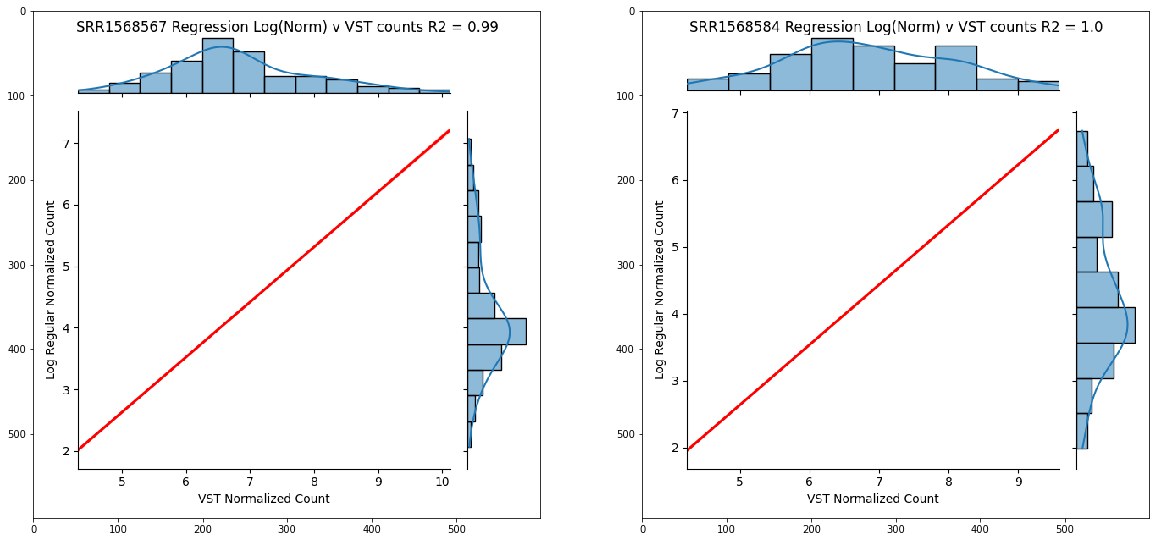

In [68]:
import matplotlib.image as mpimg

img_A = mpimg.imread('../data/out/sra_1.png')
img_B = mpimg.imread('../data/out/sra_2.png')

# display images
fig, ax = plt.subplots(1,2, figsize=(20,10))
ax[0].imshow(img_A);
ax[1].imshow(img_B);


Figure 7: Two SRA Run's regression of log norm vs VST counts. 

### PCA

We performed Principle Component Analysis (PCA) on the VST gene matrix for two PCA Plots, one with the grouping set to disorder, and another plot with the grouping set to biofluid. 

PCA uses linear combinations to explain the variance-covariance structure of a set of variables. Data reduction and data interpretation are the main reasons for the use of PCA with the latter being the method we incorporated in the replication project[<sup>8</sup>](#fn8). For the purposes of this project, we did not remove any samples from our data thus negating the need to do any sort of dimensionality reduction of our data. In doing so, we did not experience any reduction in our data in terms of size and scope which would be commmon in other PCA implementations. We used PCA purely on an exploratory level where we could observe relationships within our data that may not have been as obvious to us. 
In Figure 8 below, there are visibly two groups formed in both the left and right charts. However, the spread of every disorder and biofluid, respectively, is relatively equal across the chart.


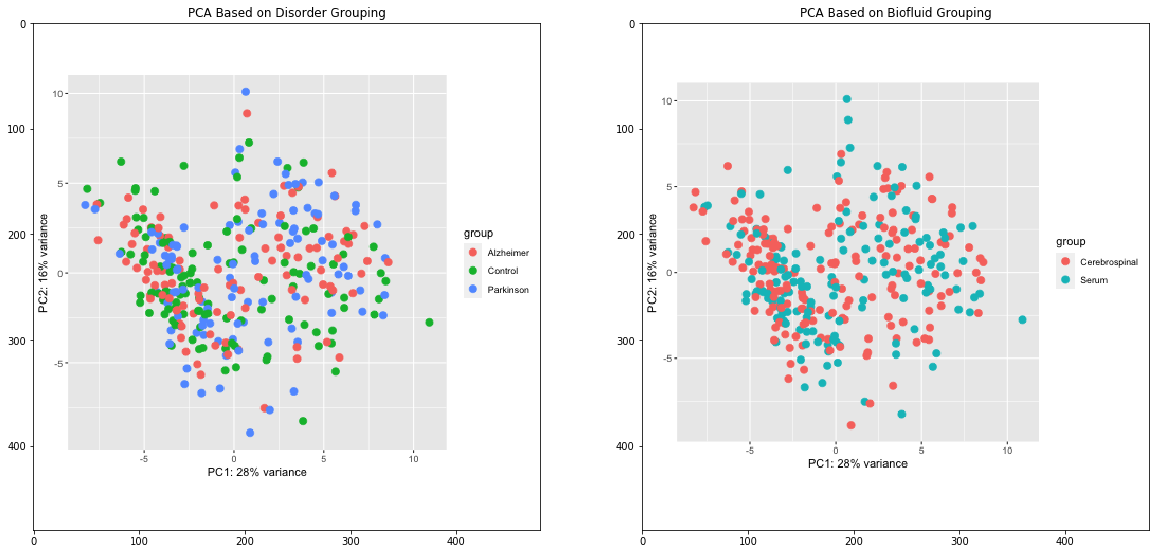

In [69]:
import matplotlib.image as mpimg

img_A = mpimg.imread('../data/out/PCAplot_Disorder.png')
img_B = mpimg.imread('../data/out/PCAplot_Biofluid.png')

# display images
fig, ax = plt.subplots(1,2, figsize=(20,10))
ax[0].imshow(img_A);
ax[1].imshow(img_B);

title = ax[0].set_title("PCA Based on Disorder Grouping")
title = ax[1].set_title("PCA Based on Biofluid Grouping")



Figure 8: (left) PCA based on grouping by disorder. (right) PCA based on grouping by biofluid.

### Missing Genes
The majority of the 180K genes are missing across all samples and are thus not relevant for analysis and comprimise quality and performance of the analysis. We can plot these genes to see the missingness percentage to see if there is a pattern related to the biofluid or gender. The plot below shows the missing genes do not have a pattern in any particular classification of patients. After removing the missing genes we end up with 132 genes that are in all the samples.

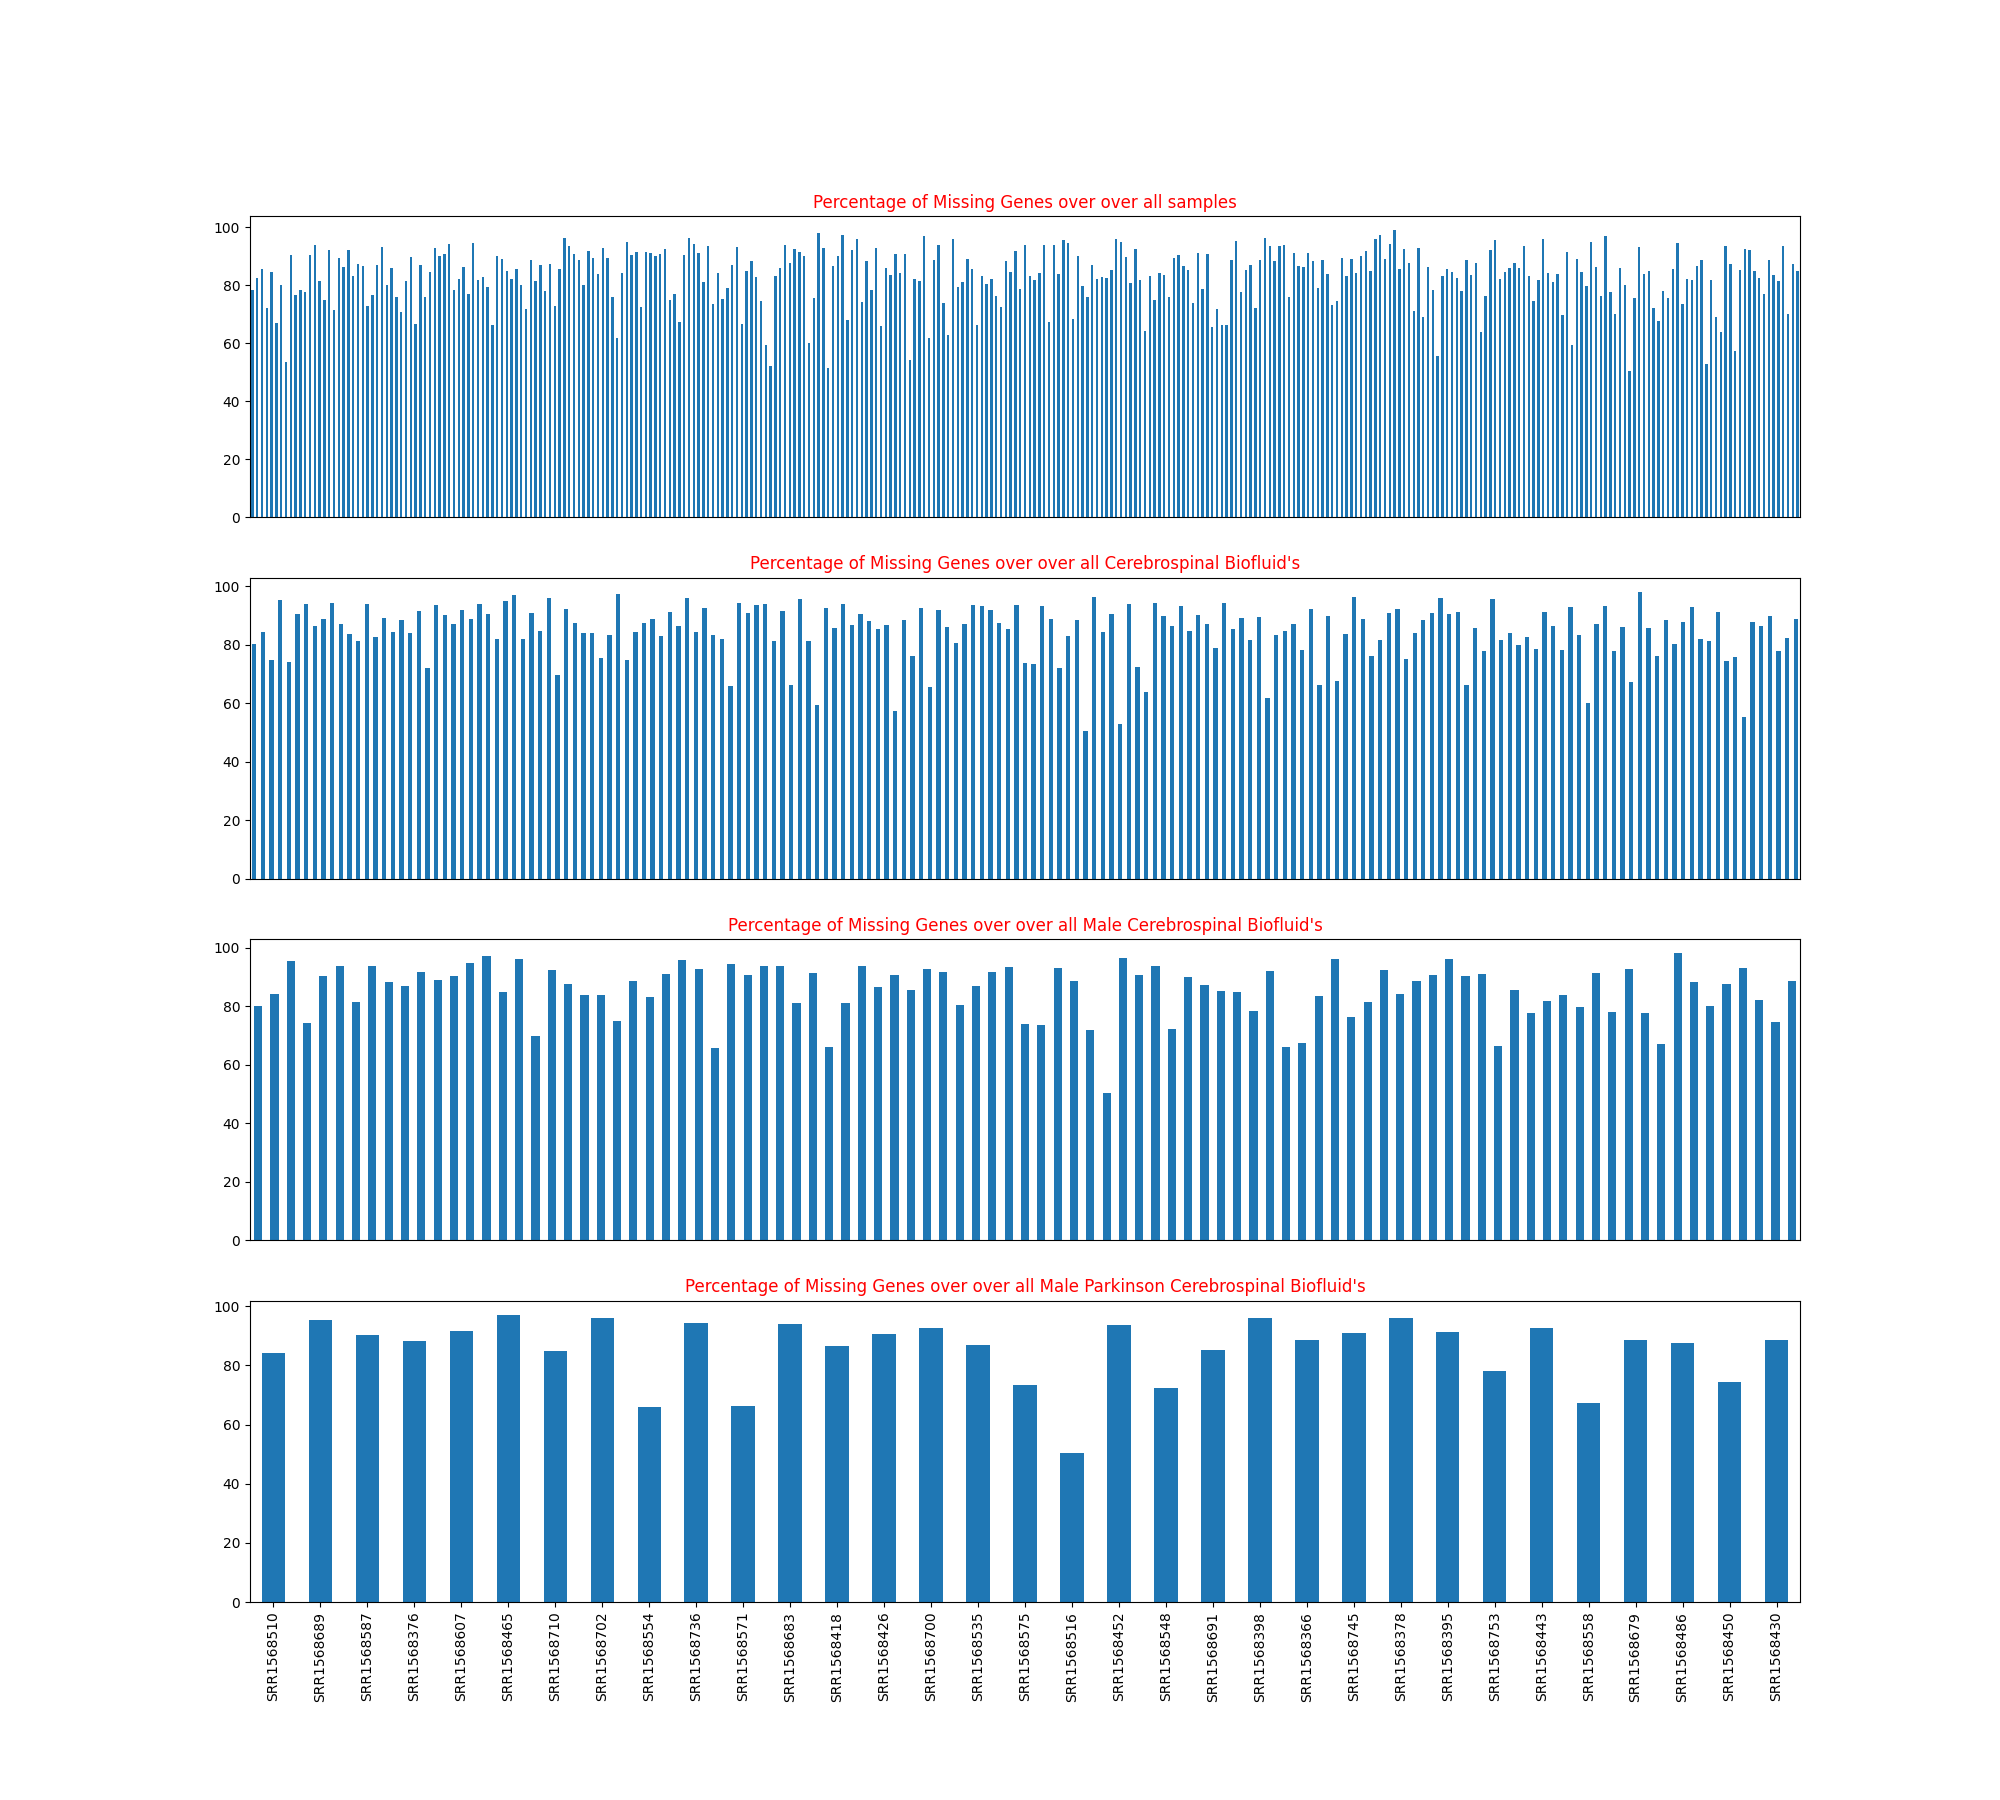

In [23]:
Image("../data/out/missing.png", width=800)

Figure 9: Missingness analysis of Genes. 

Furthermore, we can identify the top and bottom genes based on a statistic for each gene across the samples that measures the spread against the mean normalized count. Genes which had little spread are likely candidates that might not be important as they do not significantly vary across the samples. The spread statistic we developed was the L1 distance against the mean. The table below shows the top 5 and bottom 5 genes and the spread values. The gene with highest count variance was NST00000538654.1:retained_intron:SNHG1-003 and the bottom ranked gene was ENST00000365436.1:misc_RNA:Y_RNA.387-201. <font color="red"> Finally, a gene that was mentioned in the paper, EGR1 (NM_001964), was ranked number 691. This ranking could indicate some potential data quality issues resulting from kallisto which was not used for gene counting in the original study. </font>

In [24]:
def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))


df3 = pd.read_csv("../data/out/top_genes.tsv", sep='\t', index_col=0)
df3 = df3.rename({"gene": "Gene"}, axis=1)
display_side_by_side([df3.iloc[:5,:], df3.iloc[-5:,:]], ['Top Ranked Genes', 'Bottom Ranked Genes'])


,Gene,Spread
0,ENST00000538654.1:retained_intron:SNHG1-003,308.314
1,ENST00000410794.1:snRNA:RNU2-7P-201,302.874
2,ENST00000410695.1:snRNA:RNU2-37P-201,299.969
3,ENST00000387441.1:Mt_tRNA:MT-TH-201,287.011
4,ENST00000387347.2:Mt_rRNA:MT-RNR2-201,268.034
,Gene,Spread
127,ENST00000363301.1:misc_RNA:Y_RNA.130-201,94.2805
128,ENST00000363667.1:misc_RNA:RNY4P6-201,91.5179
129,ENST00000284727.4:protein_coding:ATP5G3-001,89.5493
130,ENST00000516594.1:misc_RNA:RNY4P11-201,88.2626


Table 12: (left) the top ranked genes and their spread. (right) the bottom ranked genes and their spread.

## Data Analysis

The analysis of the data was performed using the same technique in the research paper, namely to consider each biofluid separately, and within inside each biofluid to consider each disorder (versus control) separately. This resulted in 4 combinations of analysis computations that were performed.  

With the top genes identified, each of the 2 biofluids ("Serum", "Cerebrospinal fluid") we filtered only the samples for that biofluid and then further break into 2 different tables where we would only include one of the 2 disorders ("Alzheimers", "Parkinsons") plus the control.

<span style="color:red"> The basis of the analysis was the Likelihood Ratio Test (LRT), which is a hypothesis test based on a full and reduced model using the DESeq2 package. The full model was Age+PMI+pH+Disorder, and the reduced model was Age+PMI+pH. The premise of the LRT is to compare models in terms of how they fit the available data by comparing the likelihood scores of the two models[<sup>9</sup>](#fn9). The model with the higher score is considered the model that best fits the data. In order to properly use the LRT, the models being compared must be nested models meaning one model must be a "simpler" version of the other[<sup>9</sup>](#fn9). In our case, the "simpler" model is our reduced model, while our full model represents out complex model. </span>

<span style="color:red">Our process for LRT in this replication project differs from the original paper in that the PRUA was not included, which as mentioned earlier was due to not having this statistic readily available due to our choice of using kallisto. The output from the analysis was a LRT table which included the baseMean, log2 Fold Change, stat, the pvalue, and adjusted pvalue. The descriptive summary of LRT in brain region AnCg for Major Depressive Disorder is shown in Table 13 below. </span>

In [26]:
df4 = pd.read_csv("../data/out/Cerebrospinal/Parkinson/lrt.tsv", sep='\t', index_col=0)
df4.describe().round(3)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
count,132.000,132.000,132.000,132.000,132.000,132.000
mean,130.544,-0.034,0.118,1.335,0.414,0.721
std,192.789,0.147,0.031,1.847,0.277,0.149
min,9.247,-0.600,0.071,0.000,0.000,0.014
25%,43.258,-0.125,0.099,0.252,0.204,0.650
50%,61.174,-0.051,0.114,0.932,0.334,0.661
75%,115.428,0.049,0.126,1.616,0.615,0.803
max,1405.315,0.390,0.238,15.070,0.996,0.996


Table 13: The LRT descriptive summary for biofluid Cerebrospinal fluid for Parkinsons.

## Visualization

### MA Plot

The LRT data for each of the 4 comparisons was used to generate a 2x2 MA Plot shown in Figure 10 below. This is a scatter plot of the mean of the normalized counts against the log fold change. 
<span style="color:red"> The striking pattern we can see is that the brain region AnCg and the disorder for Schizophrenia shows many outliers. Our findings for the MA Plot results between schizophrenia and the anterior cingulate cortex are inline with the behavior observed by data of the schizophrenic samples within the specific brain region. Specifically, the original replication report notes that schizophrenic samples in the AnCg showed the most significant disease-related differences compared to those of the control groups[<sup>1</sup>](#fn1). </span>


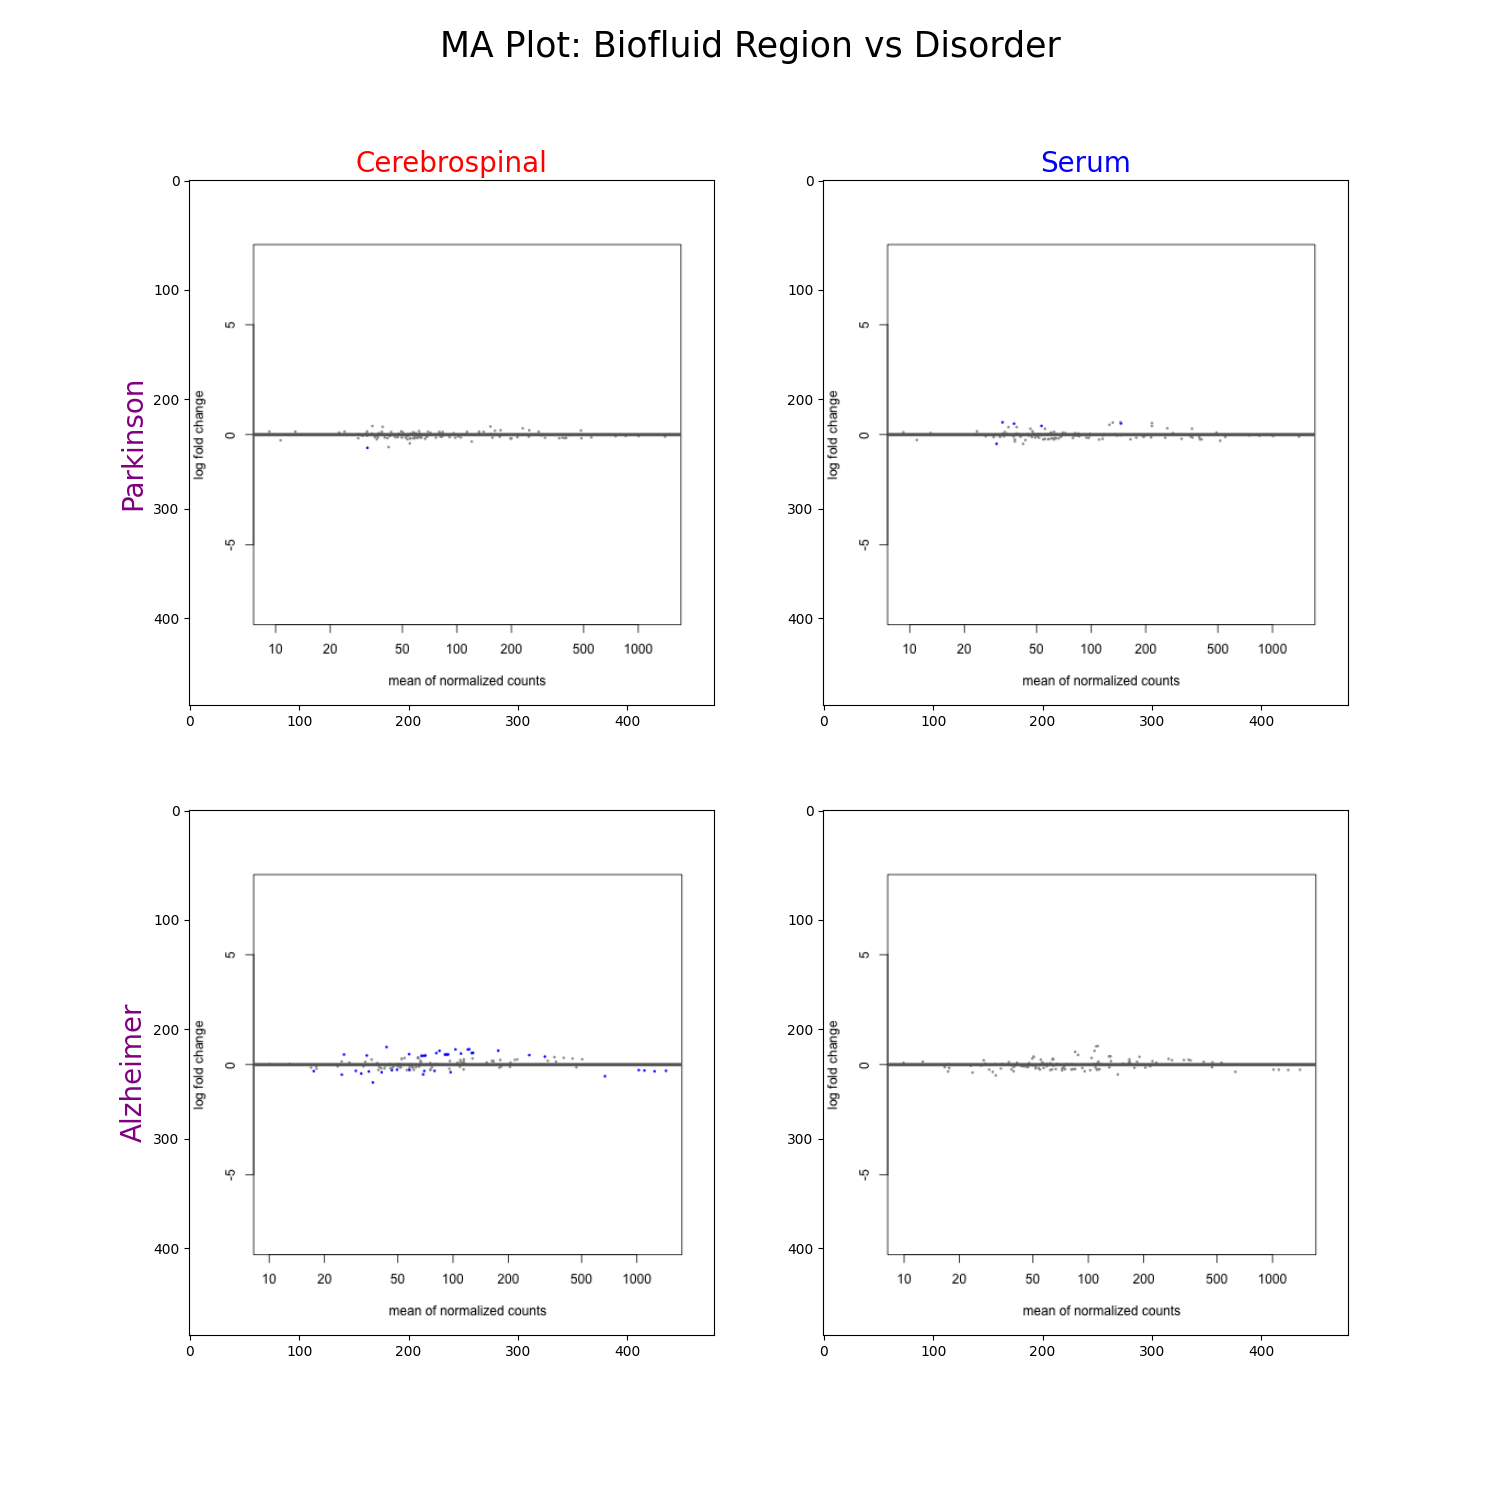

In [27]:
Image("../data/out/ma_plot.png", width=500)

Figure 10: MA Plot for each biofluid versus each disorder.

### Heat Maps

The LRT data for each of the 4 analysis regions was used to generate a 2x2 heatmaps of the top 100 genes is shown in Figure 11 below. Heatmaps allow us to observe specific values of interest across two axis variables in the form of a grid with colored cells[<sup>10</sup>](#fn10). The variables we have used for our axes are the patients and the genes identified across our patient samples, with the main value of interest being the expression of genes between patients and specific genes, which was a similar approach seen in the original replication paper. By observing our value of interest, gene expression, we can then be able to determine if any patterns or associations exist within our 9 analysis regions. Figure 11 shows clustering analysis which is particulalry suited to the VST data. <span style="color:red"> Although it is difficult to interpret the minute details in each chart, we can see that two areas are more different than others: Major Depressive in both the brain regions of DLPFC and nAcc show striking differences to the rest of the heatmaps. </span>

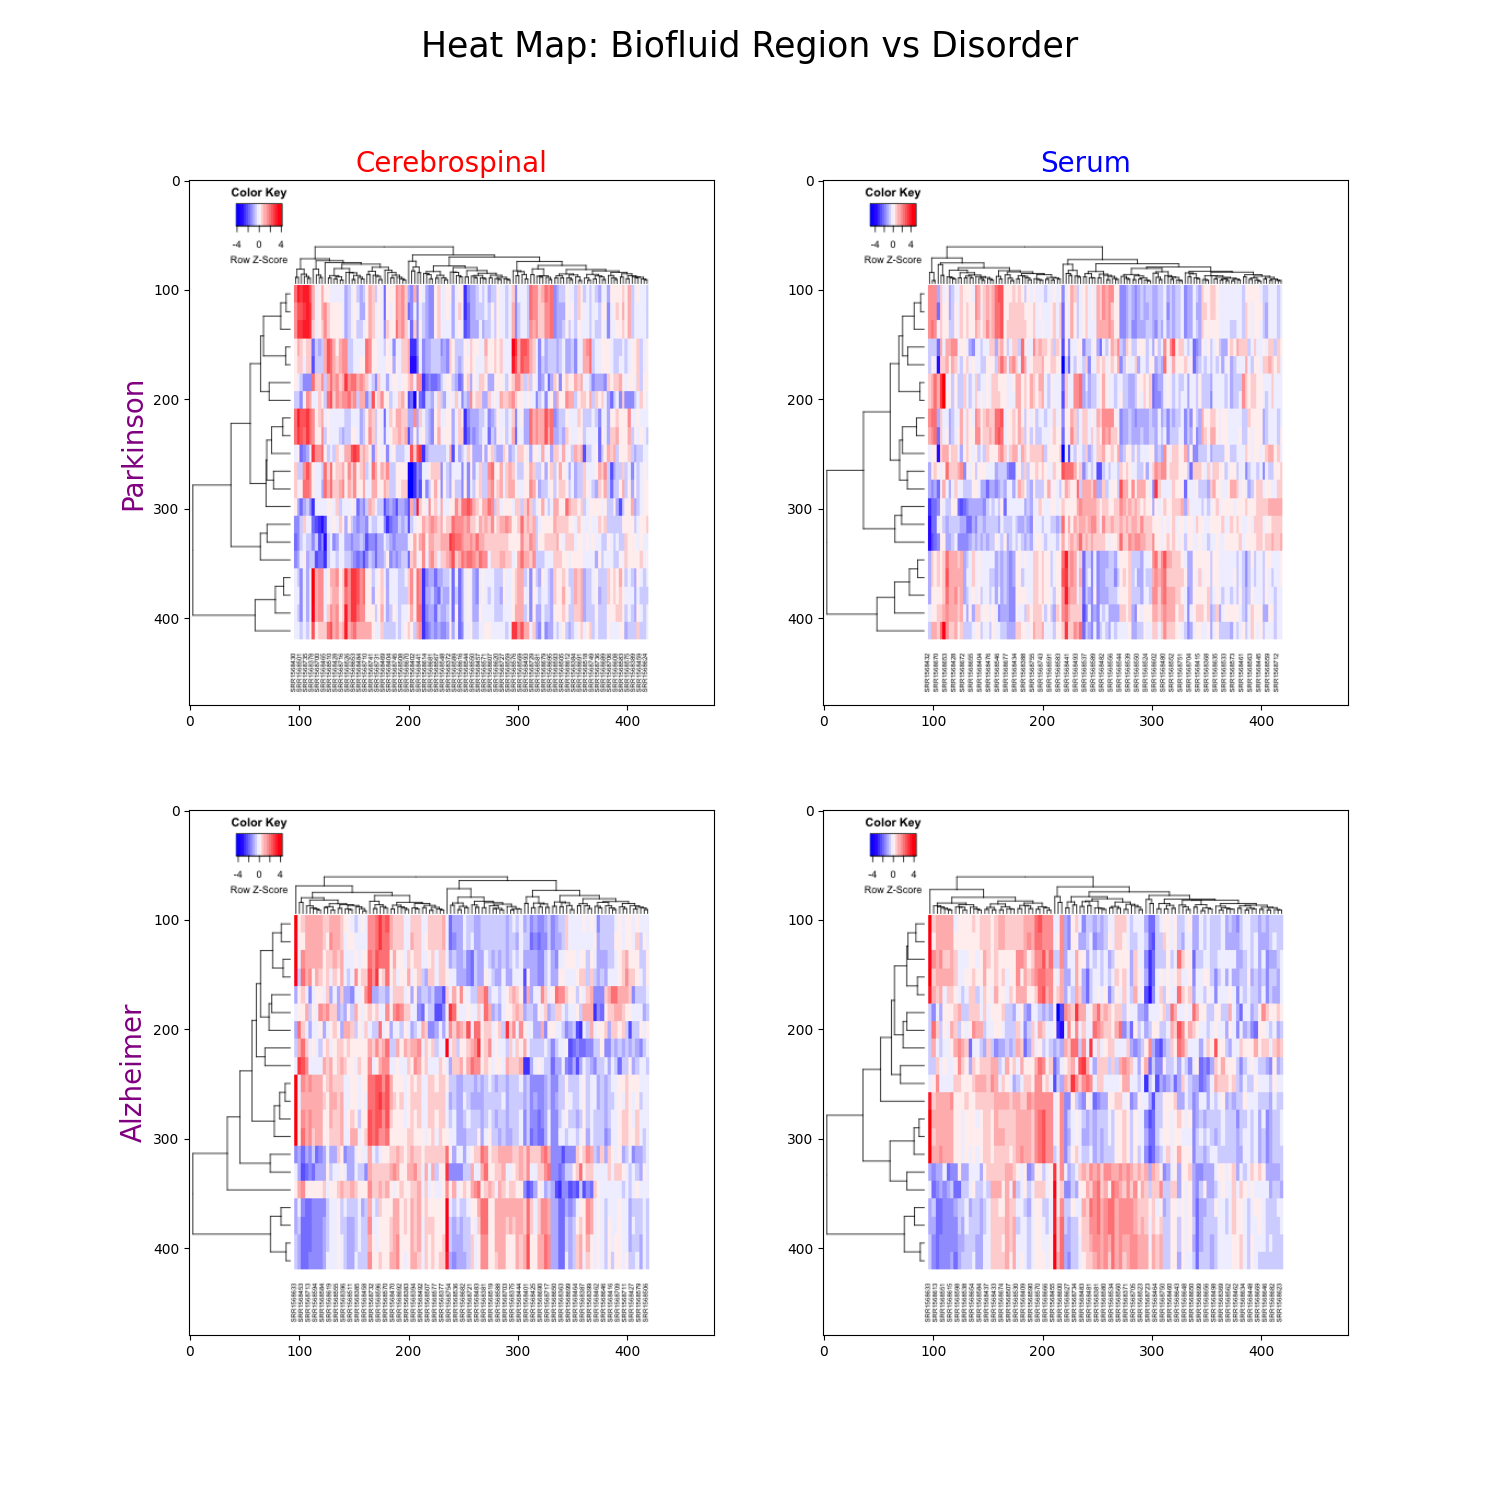

In [28]:
Image("../data/out/heat_map.png", width=500)

Figure 11: Top 100 Expressed Gene Heatmap for each biofluid versus each disorder.

### Histograms of case versus control differential expression

We repeat the same visualization in the paper for the distribution of the pvalues for each of the 4 regions shown in Figure 12 below. <span style="color:red">We see a similar profile for the Schizophrenia histograms - AnCg has a distribution which has a right skewed with a high number of samples with high statistical significance. Similarly, Schizophrenia histograms for DLPFC and nAcc show a flattish distribution. The Bipolar Disorder for AnCg also shows a similar right skewed distribution with a lower peak than Schizophrenia in this same brain region. The distributions for the other regions is not exactly the same as in the paper. However, given the large number of differences in the processing pipeline, in particular the use of kallisto, there is still a reasonable degree of correlation in these results. </span>

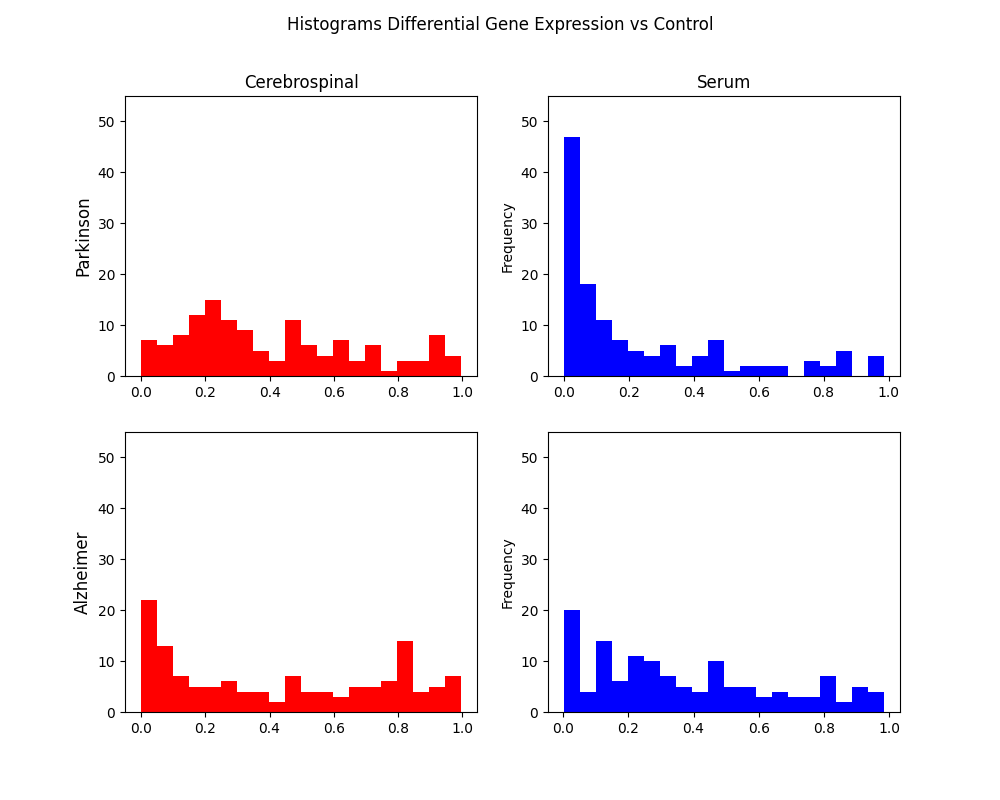

In [29]:
Image("../data/out/histogram.png", width=800)

Figure 12 - Histogram for each biofluid versus each disorder.

### Venn Diagram of Disorders 

Another visualization in the original paper is a venn diagram that shows overlap of genes differentially expressed between Parkinson (red) and Alzheimer (green) <span style="color:red"> versus CTL at p value <0.05 in the AnCg, our venn diagram is shown below in Figure 13. The actual numbers are different and is to be expected as we do not know the exact number of genes that were dropped as part of PCA in the research paper. However, there is a significant divergence in the Major Depressive Disorder with only 312 counts measured which indicates that our analysis is not replicating the same results in this disorder - this was also seen in the histogram analysis mentioned above too. This is a potential area to investigate and debug to find the cause of this divergence.</span>

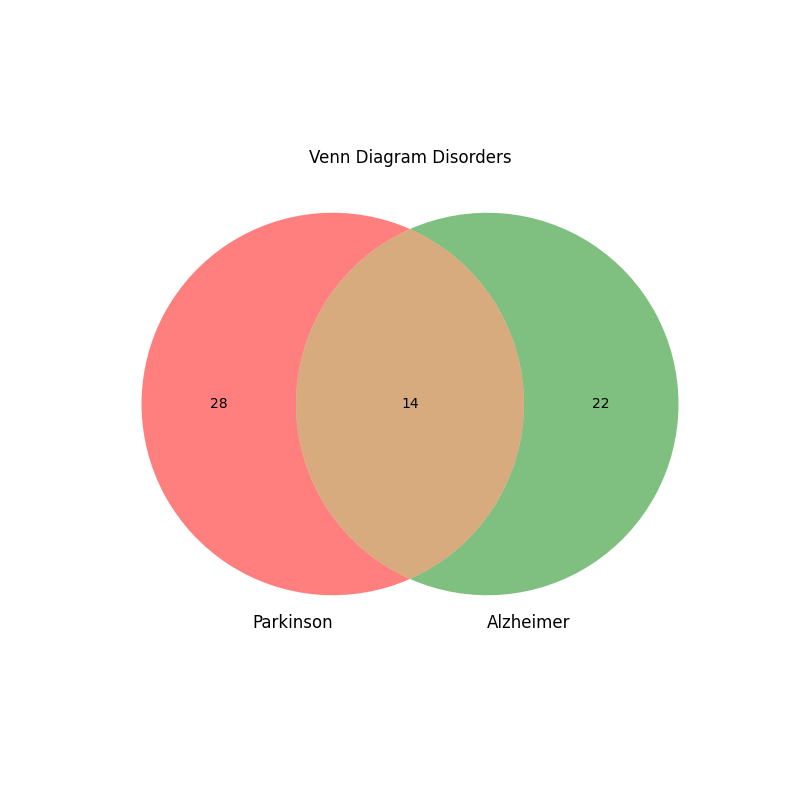

In [30]:
Image("../data/out/venn.png", width=600)

Figure 13: Venn Diagram showing genetic overlap between Parkinson and Alzheimer

### Spearman correlations of log2 fold gene expression 

We finally recreate the spearman correlation matrix that is pairwise Spearman correlations of log2 fold gene expression changes between each disorder and CTL in each biofluid. The circle sizes are scaled to reflect absolute Spearman correlations. To produce this plot we took the log2 fold gene expressions column from each of the 4 LRT analyses we performed and then use Panda's correlation function to generate a R2 pearson correlation number.

The results are shown below in Figure 14. <span style="color:red"> One particularly interesting point is that we see a high degree of correlation between Schizophrenia and Bipolar disorders in the AnCg brain region, this was also noted in the research paper and is a likely confirmation that our results have some level of validity. </span>


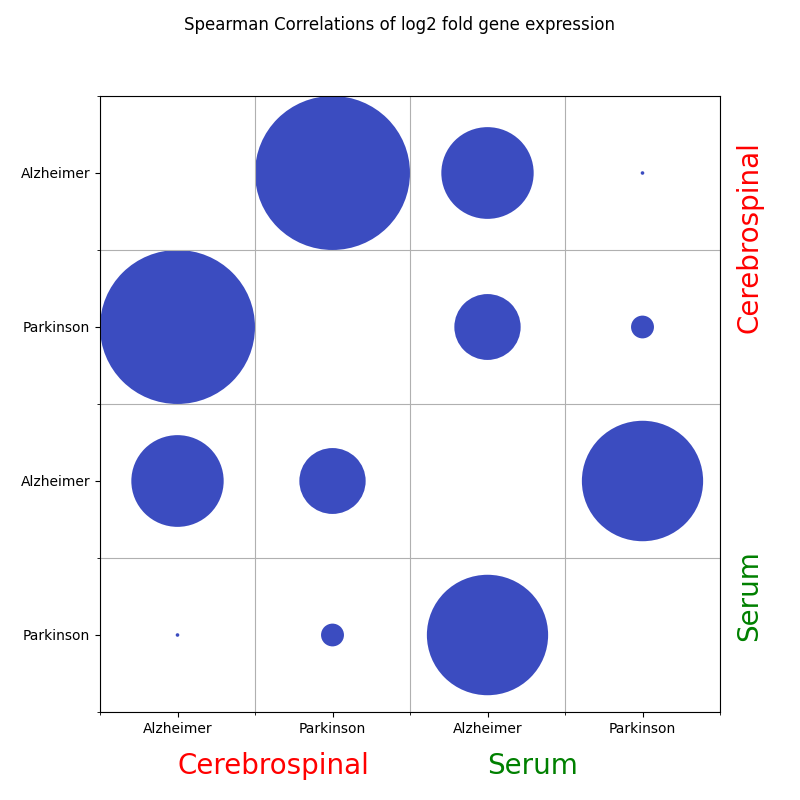

In [31]:
Image("../data/out/corrmatrix.png", width=600)

Figure 14 - Spearman correlation of log2 fold gene expression for each biofluid against each disorder.

## Conclusion TODO

<span style="color:red"> #TODO </span>
We have shown a reproduction of the brain and disorder analysis using gene expressions. To accomplish this we have developed a robust pipeline which takes SRA fastq files and outputs visualizations that are in the original paper. Although we do not match the exact results, we have shown that we do find that there is a high degree of correlation in the AnCg brain region between Schizophrenia and Bipolar disorders. However, we have found our results diverge in the Major Depressive disorder. This discrepency could have occurred because of several decisions we made different from the original paper:

- We decided to develop a custom pipeline instead of using the aRNAPipe. aRNAPipe is used in the paper and is very powerful but we decided we wanted to call the tools (cutadapt, kallisto, etc) directly in our own pipeline as it gives us more ability to understand what is going on, more flexibility, and we think it will be easier to debug in the future.

- We performed gene counts with kallisto rather than STAR. This decision was based on practiciality, as kallisto is faster for processing compared to STAR. As STAR aligns to the reference genome and kallisto does pseudoalignment on the transcriptome quantification, the results will be different. Furthermore, we were not able to use the PRUA statistic from STAR in our analysis which lead our full and reduced models in the LRT to have one less feature.

Overall, this was a great learning experiance for both of the team members. Not only was it a technically challenging project from learning new tools and developing a sophisticated pipeline, but we also learned about the biology of genes and approaches of using gene expression to analyse massive real-world datasets. This project also allowed us to appreciate the data challenges that data scientists in the genetics field face, from incomplete data to massive computation challenges to clean and process the biological sample datasets. 


## Appendix  TODO

### Project Targets

#### target: data
•	To process the data, from the root project directory run the command:

    python3 run.py data

•   The data pipeline step takes the .fastq compressed files as input and then applies two transformations: process and align

•	This pipeline step also uses an additional CSV file that is the SRA run database, a sample looks like as follows:

    Run age_at_death    Brain_pH    brain_region    Bytes   Center Name clinical_diagnosis
    SRR3438555  40  6.76    AnCg    2585349730  GEO Control



•   The configuration files for the data step are stored in config/data-params.json. These include the parameters for the tools as well as the directories used for storing the raw, temporary and output files.

    "raw_data_directory": "./data/raw",
    "tmp_data_directory": "./data/tmp",
    "out_data_directory": "./data/out",

•   The configuration also includes an attribute to the SRA run input database (described above), and an attribute of where to store that in the data folder. Additional filter attributes are included for ease of use to avoid processing all patients, if this filter_enable is set it will only process a subset of SRA rows (filter_start_row to filter_start_row + filter_num_rows).

    "sra_runs" : {
        "input_database" : "/datasets/srp073813/reference/SraRunTable.csv",
        "output_database" : "data/raw/SraRunTable.csv",
        "filter_enable" : 0,
        "filter_start_row" : 120,
        "filter_num_rows" : 10   
    },
    

•	The first transformation of the data is "process" that uses the following data configuration below. Otherwise it will invoke cutadapt which finds and removes adapter sequences. The attributes include the adapters (r1 and r2) to identify the start and end of pairs are a JSON array. The attribute enable allows to disable this cleaning step, instead it will simply copy the paired files from the source dataset. The arguments attribute allows flexible setting of any additional attribute to the cutadapt process. Finally, we have two wildcard paths that indicate the location of the SRA fastq pair files (fastq1 and fastq2).

    "process" : {
        "enable" : 1,
        "tool" : "/opt/conda/bin/cutadapt",
        "r1_adapters" : ["AAAAA", "GGGG"],
        "r2_adapters" : ["CCCCC", "TTTT"],
        "arguments" : "--pair-adapters --cores=4",
        "fastq1_path" : "/datasets/srp073813/%run_1.fastq.gz", 
        "fastq2_path" : "/datasets/srp073813/%run_2.fastq.gz"
    },
    
•   The second transformation of the data is "aligncount" that can be set to either use STAR or Kallisto. The choice of STAR or kallisto step is controlled by the aligncount attribute:

    "aligncount" : "kallisto",

•   kallisto uses the index_file attribute is the location of the directory of the reference genome, which for this replication project was GRCh37_E75. The arguments attribute allows flexible setting of any additional attribute to the kallisto process. Including the bootstaro samples.The attribute enable allows to disable this alignment step, this is useful for debugging the process prior step, for example, you can run quality checks on the processed fastq files before proceeding to alignment. 

    "kallisto" : {
        "enable" : 1,
        "tool" : "/opt/kallisto_linux-v0.42.4/kallisto",
        "index_file" : "/datasets/srp073813/reference/kallisto_transcripts.idx",
        "arguments" : "quant -b 8 -t 8"
    },

•   STAR uses the gene_path attribute is the location of the directory of the reference genome, which for this replication project was GRCh37_E75 as described in the reference_gene attribute. The arguments attribute allows flexible setting of any additional attribute to the STAR process. Including TranscriptomeSAM in the quantMode arguments will also output bam files. Additionally, the log file gets outputted which has PRUA (percentage of reads uniquely aligned). The attribute enable allows to disable this alignment step, this is useful for debugging the process prior step, for example, you can run quality checks on the processed fastq files before proceeding to alignment. 

    "STAR" : {
        "enable" : 1,
        "tool" : "/opt/STAR-2.5.2b/bin/Linux_x86_64_static/STAR",
        "reference_gene" : "GRCh37_E75",
        "gene_path" : "/path/to/genomeDir",
        "arguments" : "--runMode alignReads --quantMode GeneCounts --genomeLoad LoadAndKeep --readFilesCommand zcat --runThreadN 8"
    },

•   The process and align transformation work on each of the samples. After each sample iteration, the temporary fastq files will be deleted to reduce storage requirements.


•   Example processing:

    python3 run.py data

    # ---------------------------------------------------
    # Process
    # ---------------------------------------------------
    # Starting sample # 1  out of  352
    /opt/conda/bin/cutadapt --pair-adapters --cores=4  -a AAAAA -a GGGG -A CCCCC -A TTTT -o ./data/tmp/out.1.fastq.gz -p ./data/tmp/out.2.fastq.gz /datasets/srp073813/SRR3438555_1.fastq.gz /datasets/srp073813/SRR3438555_2.fastq.gz
    /opt/kallisto_linux-v0.42.4/kallisto quant -b 100 -i /datasets/srp073813/reference/kallisto_transcripts.idx ./data/tmp/out.1.fastq.gz ./data/tmp/out.2.fastq.gz -o ./data/tmp/SRR3438555_ReadsPerGene.out.tab
    rm ./data/tmp/out.1.fastq.gz
    rm ./data/tmp/out.2.fastq.gz
    # ---------------------------------------------------
    # Starting sample # 2  out of  352
    /opt/conda/bin/cutadapt --pair-adapters --cores=4  -a AAAAA -a GGGG -A CCCCC -A TTTT -o ./data/tmp/out.1.fastq.gz -p ./data/tmp/out.2.fastq.gz /datasets/srp073813/SRR3438556_1.fastq.gz /datasets/srp073813/SRR3438556_2.fastq.gz
    /opt/kallisto_linux-v0.42.4/kallisto quant -b 100 -i /datasets/srp073813/reference/kallisto_transcripts.idx ./data/tmp/out.1.fastq.gz ./data/tmp/out.2.fastq.gz -o ./data/tmp/SRR3438556_ReadsPerGene.out.tab
    rm ./data/tmp/out.1.fastq.gz
    rm ./data/tmp/out.2.fastq.gz
    # ---------------------------------------------------


#### target: merge
•   To merge gene count and/or BAM files generated from the data target, from the root project directory run the command:

    python3 run.py merge

•   The configuration files for the data step are stored in config/count-params.json. These include the parameters for the count merge and bam merge and it's associated arguments.

•   The format attrbute informs if to process kallisto (or STAR) files. The gene counts are merged into a TSV file and as well as a A feature table based on the SRA run table. Additional STAR attributes in the JSON allow you to specify skiprows used when processing the STAR gene count files as well as identifying the column from the STAR gene matrix file to use as the column used to. The STAR log files (with PRUA information) and add an additional PRUA features to feature table. You can limit the features by setting the "features" json attribute to only the features you want to have. There is an additional imputes attribute that allows you to impute any column with missing data. The attributes also include the "filter_names" gene table used to remove X and Y chromosomes as well as removing false-positive genes. Finally, we can rename the freature columns before we save out the feature table.

    "count" : {
        "enable" : 1,
        "format" : "kallisto",
        "skiprows" : 4,
        "column_count" : 4,
        "skip_samples" : ["SRR3438888"],
        "filter_keep_genes" : "NM_",
        "filter_remove_genes" : ["chrX", "chrY"],
        "filter_names" : "/datasets/srp073813/reference/Gene_Naming.csv",
        "run_database" : "data/raw/SraRunTable.csv",
        "imputes" : ["Brain_pH"],
        "features" : ["Run", "clinical_diagnosis", "age_at_death", "Brain_pH", "brain_region", "post-mortem_interval"],
        "rename" : {"age_at_death" : "Age", "post-mortem_interval": "PMI", "Brain_pH": "pH", "clinical_diagnosis" : "Disorder"},
        "output_matrix" : "data/out/gene_matrix.tsv",
        "output_features" : "data/out/features.tsv"
    },

•   For bam merging, which should not be enabled by default, we use the "samtools" merge feature that takes all the BAM files and combine them into one merged BAM file. 


    "bam" : {
        "enable" : 0,
        "output" : "data/tmp/merged.bam",
        "tool" : "/usr/local/bin/samtools",
        "arguments" : "merge --threads 8"
    },


•   Example processing:

    python3 run.py merge

    # ---------------------------------------------------
    # Merge
    Input: SRR3438605_ReadsPerGene.out.tab
    Input: SRR3438604_ReadsPerGene.out.tab
    Output: data/out/gene_matrix.tsv data/out/features.tsv
    # Finished
    # ---------------------------------------------------



#### target: normalize
•   To normalize the aligned merge counts, from the root project directory run the command:

    python3 run.py normalize

•   The configuration files for the data step are stored in config/normalize-params.json. 

•   We use a custom R script which uses the DESeq2 module to take the input merged gene counts and the experiment features and outputs two normalized counts files. The analysis is done for all samples in the SRA run table. The output_dir sets the output location for the normalized count matrix files. One file is the standard normalized counts using the DESeq2 module, and the second normalized count file is after a Variable Stablization Transform (LRT). We also have a "max_genes" attribute that will filter the genes and removes ones that have little to no variance across disorder vesus control.

•   The data JSON configuration file also holds an array of samples, a sample looks like as follows:
    
    {
        "output_dir" : "data/out",
        "DESeq2" : {
            "Rscript" : "/opt/conda/envs/r-bio/bin/Rscript",
            "source" : "src/data/normalize.r",
            "input_counts" : "data/out/gene_matrix.tsv",
            "input_features" : "data/out/features.tsv",
            "max_genes" : 8000
        },
        "cleanup" : 0,
        "verbose": 1
    }

•   Example processing:

    python3 run.py normalize

    # ---------------------------------------------------
    # Normalize
    Rscript  src/data/normalize.r data/out/gene_matrix.tsv data/out/features.tsv data/out/
    [1] "Output data/out/normalized_counts.tsv data/out/vst_transformed_counts.tsv"
    # Finished
    # ---------------------------------------------------

#### target: analysis
•   To perform the analysis for the gene counts, from the root project directory run the command:

    python3 run.py analysis

•   The configuration files for the data step are stored in config/analysis-params.json. 

•   We use a custom R script which uses the DESeq2 module to take the input merged gene counts and the experiment features and outputs 3 sets of files for each brain region. Each brain region will compare a disorder versus Control. This will result in a total of 9 sets of files (3 brain regions x 3 disorder pair comparisons). Each output set includes a Likelihood Ratio Test (LRT) using the full and reduced model as specified in the attributes below as well as a MA-Plot and Heatmap. The additional attributes include the property of doing parallel processing for DESeq2.
    
    {
        "output_prefix" : "data/out/%brain_region%",
        "DESeq2" : {
            "Rscript" : "/opt/conda/envs/r-bio/bin/Rscript",
            "brain_regions" : ["AnCg", "nAcc", "DLPFC"],
            "disorders" : ["Major Depression", "Schizophrenia", "Bipolar Disorder"],
            "control" : "Control",
            "disorder_comparisons" : [["Major Depression", "Bipolar Disorder"], ["Major Depression", "Schizophrenia"], ["Bipolar Disorder", "Schizophrenia"]],
            "input_counts" : "data/out/pca_normalized_counts.tsv",
            "input_features" : "data/out/features.tsv",
            "source" : "src/analysis/analysis.r",
            "full" : "Age+PMI+pH+Disorder",
            "reduced" : "Age+PMI+pH",
            "parallel" : 0
        },
        "cleanup" : 0,
        "verbose": 1
    }

•   Example processing:

    python3 run.py analysis

    # ---------------------------------------------------
    # Normalize
    Rscript src/analysis/analysis.r data/out/AnCg/gene_matrix.tsv data/out/AnCg/features.tsv data/out/AnCg/Major_Depression_vs_Bipolar_Disorder/ Age+PMI+pH+Disorder Age+PMI+pH
    ...

#### target: visualize

•   The visualize pipeline step can be invoked as follows:

    python3 run.py visualize

•   The configuration files for the data step are stored in config/visualize-params.json. The output will include 7 sets of charts: Gene Spread Variance Histogram, SRA Linear Correlation between SRA chart, MA-Plot 3x3 chart, Heat Map 3x3 chart, 3x3 Histogram, 9x9 Correlation Matrix and a Disorder Venn Diagram. Each chart type has flexible settings to control the input and layout for the charts. For example, a few chart configurations are shown below:

        "heat_map" : {
            "enable" : 1,
            "brain_regions" : ["AnCg", "DLPFC", "nAcc"],
            "disorders" : ["Schizophrenia", "Bipolar_Disorder","Major_Depression"],
            "src_image" : "heatmap.png",
            "title" : "Heat Map: Brain Region vs Disorder"
        },
        "histogram" : {
            "enable" : 1,
            "brain_regions" : ["AnCg", "DLPFC", "nAcc"],
            "disorders" : ["Schizophrenia", "Bipolar_Disorder","Major_Depression"],
            "title" : "Histograms Differential Gene Expression vs Control",
            "ylim" : 1600
        },


•   Example processing:

    python3 run.py visualize

    # ---------------------------------------------------
    # Analysis
    mkdir data/out/AnCg/
    mkdir data/out/AnCg/Major_Depression/
    AnCg x Major Depression vs control
    Rscript src/analysis/analysis.r data/out/AnCg/gene_matrix.tsv data/out/AnCg/features.tsv data/out/AnCg/Major_Depression/ full=Age+PMI+pH+Disorder reduced=Age+PMI+pH charts=1
    ...
    # Finished
    # ---------------------------------------------------

#### target: qc

•   The quality pipeline step can be invoked as follows:

    python3 run.py qc

•   The configuration files for the data step are stored in config/qc-params.json. These include the parameters for the output directory where the quality HTML reports will be outputted. 

    "outdir" : "data/out",
    "inputs" : "data/tmp",

•   For fastq files, the quality tool attribute is set to fastqc and that includes attributes to extract reports or keep them in a zip file. To enable this quality check make sure you set the cleanup to 0 in the data configuration pipeline as well as to disable the STAR processing, this will retain the fastq.qz files after the data pipeline step is executed.

    "fastq" : {
        "enable" : 1,
        "tool" : "/opt/FastQC/fastqc",
        "extract" : 1   
    },

•   For bam files, the quality tool attribute is set to picard and that includes attributes such as collecting alignment summary metrics. To enable this quality check make sure you set the cleanup to 0 in the data configuration pipeline and add 'TranscriptomeSAM' to the arguments for STAR which will then output BAM files that will be retained after the data pipeline step is executed.

    "bam" : {
        "enable" : 1,
        "tool" : "java",
        "jar" : "/opt/picard-tools-1.88/CollectAlignmentSummaryMetrics.jar"
    },
    

•   Example processing:

    python3 run.py qc

    # ---------------------------------------------------
    # Quality Check
    fastqc data/tmp/out.1.fastq.gz --outdir=data/out --extract
    fastqc data/tmp/out.2.fastq.gz --outdir=data/out --extract
    java -jar /opt/picard-tools-1.88/CollectAlignmentSummaryMetrics.jar INPUT=data/tmp/SRR3438604_Aligned.bam OUTPUT=data/out/SRR3438604_Aligned.bam.txt
    java -jar /opt/picard-tools-1.88/CollectAlignmentSummaryMetrics.jar INPUT=data/tmp/SRR3438605_Aligned.bam OUTPUT=data/out/SRR3438605_Aligned.bam.txt
    # Finished
    # ---------------------------------------------------

#### target: report
•   To generate the report from the notebook, run this command:

    python3 run.py report

•   The configuration files for the data step are stored in config/report-params.json. 

    {
        "tool": "jupyter",
        "args": "nbconvert --no-input --to html --output report.html notebooks/report.ipynb",
        "verbose" : 1
    }


#### target: clean 

•	To clean the data (remove it from the working project), from the root project directory run the command:

python3 run.py clean


#### target: all 

•   The all target will execute the following steps in sequence: data, merge, normalize, analysis and visualize. It can be executed as follows:

python3 run.py all


## Additional EDA Analysis TODO

#EDA that doesn't go at top goes here

## References TODO

[1]
<span id="fn1">
Ryne C. Ramaker, Kevin M. Bowling, Brittany N. Lasseigne, Megan H. Hagenauer, Andrew A. Hardigan, Nicholas S. Davis, Jason Gertz, Preston M. Cartagena, David M. Walsh, Marquis P. Vawter, Edward G. Jones, Alan F. Schatzberg, Jack D. Barchas, Stanley J. Watson, Blynn G. Bunney, Huda Akil, William E. Bunney, Jun Z. Li, Sara J. Cooper, and Richard M. Myers. Post-mortem molecular profiling of three psychiatric disorders. Genome Medicine, 9(1):72, July 2017. URL: https://doi.org/10.1186/s13073-017-0458-5, doi:10.1186/s13073-017-0458-5. 
</span>

[2] 
<span id="fn2">
NIMH » Schizophrenia. URL: https://www.nimh.nih.gov/health/topics/schizophrenia/index.shtml.
</span>

[3] 
<span id="fn3">
NIMH » Bipolar Disorder. URL: https://www.nimh.nih.gov/health/topics/bipolar-disorder/index.shtml.
</span>

[4] 
<span id="fn4">
NIMH » Depression. URL: 
https://www.nimh.nih.gov/health/topics/depression/index.shtml.
</span>

[5]
<span id="fn5">
Zhong Wang, Mark Gerstein, and Michael Snyder. RNA-Seq URL: a revolutionary tool for transcriptomics \textbar Nature Reviews Genetics. Nature Reviews Genetics, January 2009. URL: https://www.nature.com/articles/nrg2484.
</span>

[6]
<span id="fn6">
Martin, Marcel Bioinformatics in Action (2011) URL: http://journal.embnet.org/index.php/embnetjournal/article/view/200/479
</span>

[7]
<span id="fn7">
Andrews, S. Babraham Bioinformatics URL: https://www.bioinformatics.babraham.ac.uk/projects/fastqc/ 
</span>

[8]
<span id="fn8">
PCA Explanation URL: https://www.originlab.com/doc/Origin-Help/PrincipleComp-Analysis#:~:text=Principal%20Component%20Analysis%20(PCA)%20is,as%20a%20dimensionality%2Dreduction%20technique.
</span>

[9]
<span id="fn9">
LRT, URL: http://evomics.org/resources/likelihood-ratio-test/
</span>

[10]
<span id="fn10">
Heatmap, URL: https://chartio.com/learn/charts/heatmap-complete-guide/ 
</span>

[11]
<span id="fn11">
VST URL: https://en.wikipedia.org/wiki/Variance-stabilizing_transformation
</span>

[12]
<span id="fn12">
Understanding Normalization, URL:https://towardsai.net/p/data-science/how-when-and-why-should-you-normalize-standardize-rescale-your-data-3f083def38ff#:~:text=Similarly%2C%20the%20goal%20of%20normalization,in%20the%20ranges%20of%20values.&text=So%20we%20normalize%20the%20data,variables%20to%20the%20same%20range.
</span>

[13]
<span id="fn13">
Diana Kwon, Are Some Psychiatric Disorders a pH Problem? URL: https://www.scientificamerican.com/article/are-some-psychiatric-disorders-a-ph-problem/
</span>

[14]
<span id="fn14">
Pandas - Merge Function URL: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html
</span>

[15]
<span id="fn15">
DESeq2: Love et al. Genome Biology (2014) URL: https://genomebiology.biomedcentral.com/articles/10.1186/s13059-014-0550-8
</span>